In [1]:
import segmentation
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import nibabel as nib
import SimpleITK as sitk
import numpy as np

## Run once for creating masks

In [2]:
segmentation.create_masks()

100%|██████████| 5/5 [00:00<00:00, 27.63it/s]


100%|██████████| 5/5 [00:00<00:00, 48.08it/s]


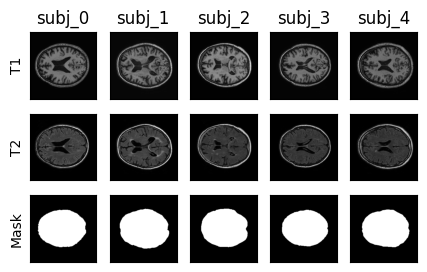

In [3]:
fig, ax = plt.subplots(3, 5, figsize=(5, 3))

layer = 25 
  
for i in tqdm(range(5)):
    t1 = nib.load(os.path.join('..','P2_Data',f'{i}','T1.nii')).get_fdata()
    t2 = nib.load(os.path.join('..','P2_Data',f'{i}','T2_FLAIR.nii')).get_fdata()
    bm = nib.load(os.path.join('..','P2_Data',f'{i}','brainMask.nii')).get_fdata()
        
    titles = ['T1', 'T2', 'Mask']
    for k, img in enumerate([t1, t2, bm]):
            if k == 0:
                ax[k, i].set_title(f'subj_{i}')
            ax[k, i].set_xticks([])
            ax[k, i].set_yticks([])
            if i == 0:
                ax[k, i].set_ylabel(titles[k])
            ax[k, i].imshow(img[:, :, layer], cmap='gray')
            
plt.show()

------------ Subject 0---------------------


 45%|████▌     | 45/100 [00:10<00:12,  4.37it/s]


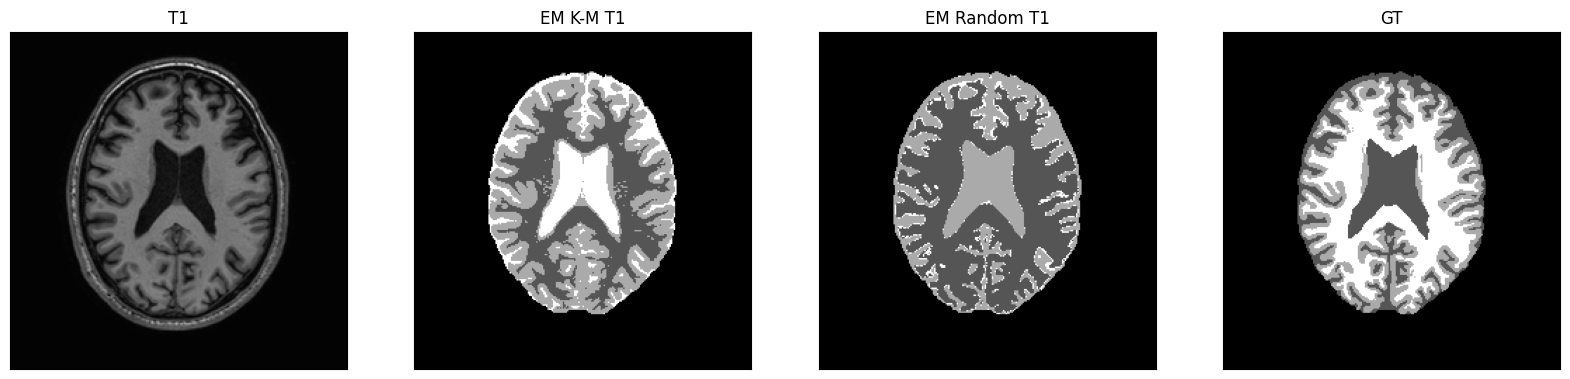

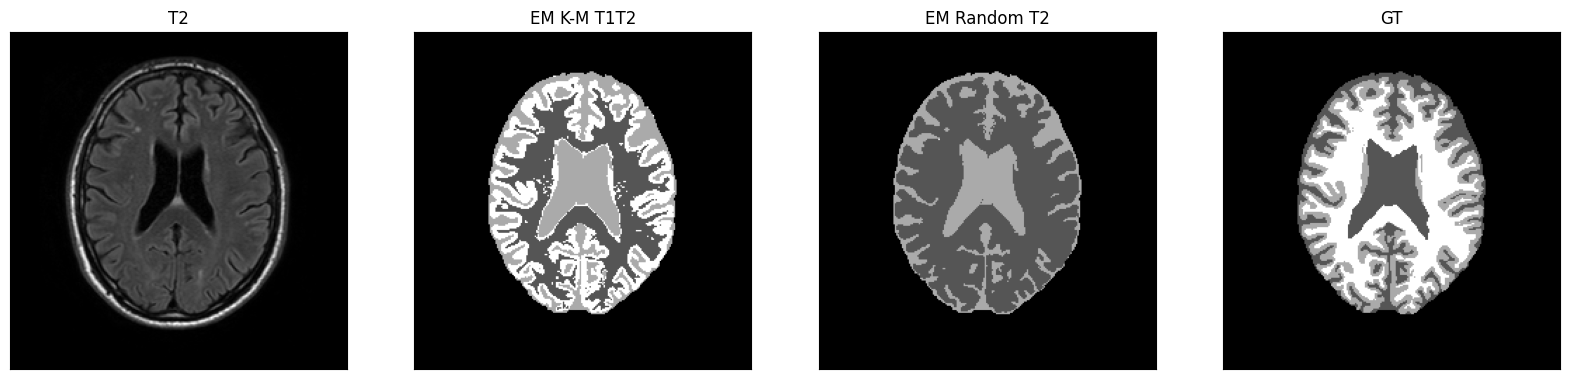

After matching areas


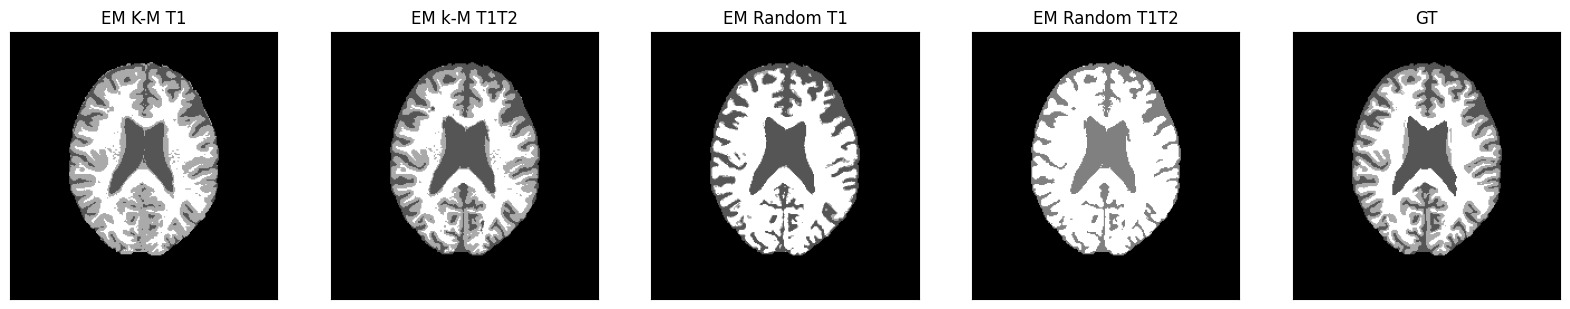

------------ Subject 1---------------------


 83%|████████▎ | 83/100 [00:19<00:03,  4.32it/s]


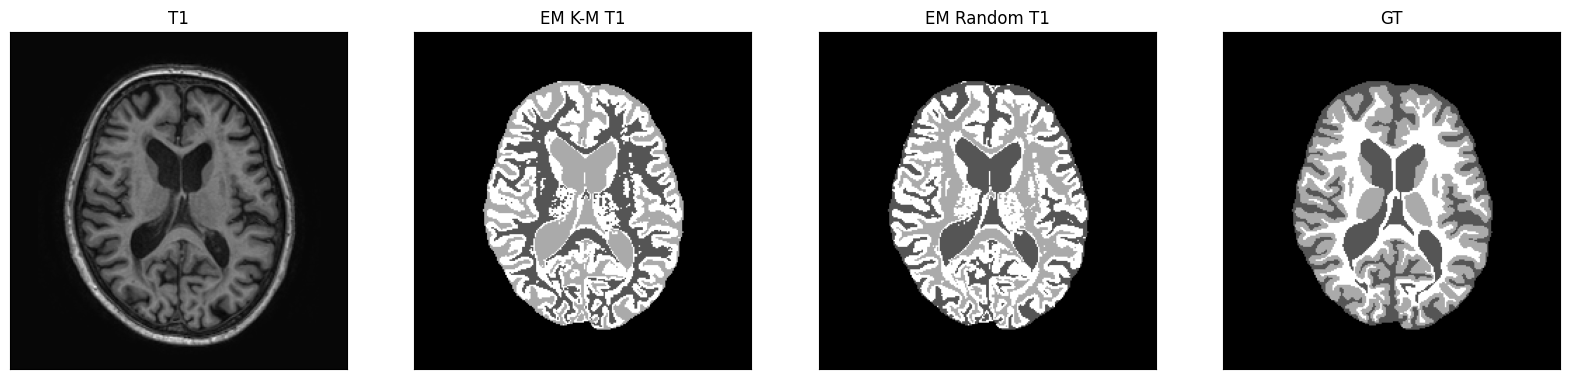

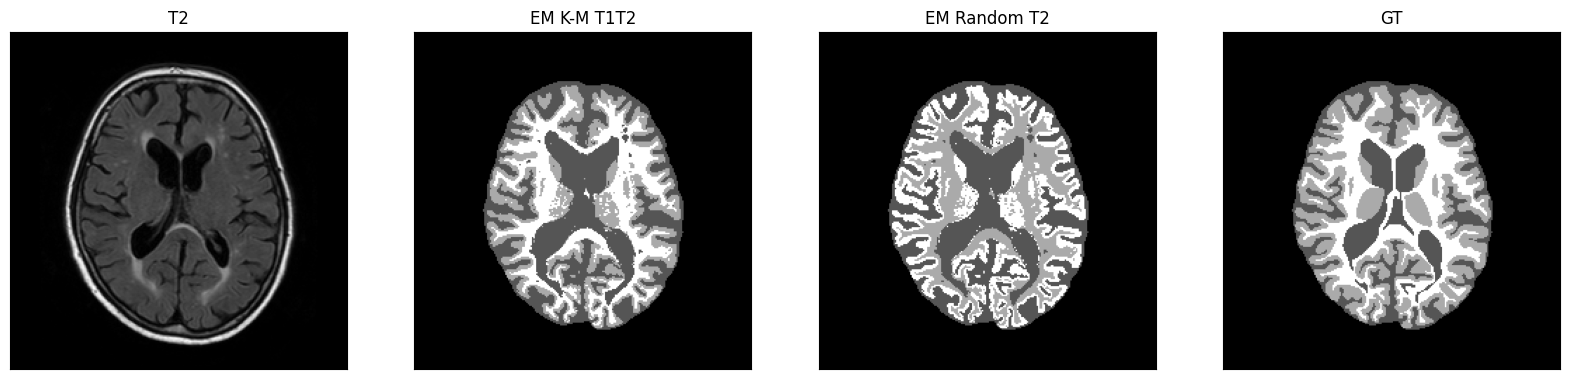

After matching areas


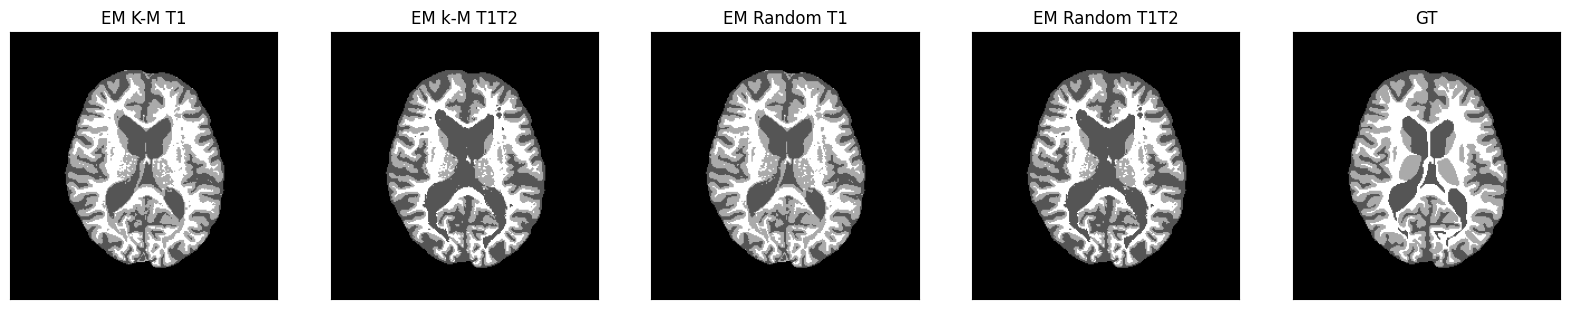

------------ Subject 2---------------------


 59%|█████▉    | 59/100 [00:09<00:06,  6.41it/s]


In [4]:
t1_seg, t2_seg = [], []
for i in range(5):
    print(f'------------ Subject {i}---------------------')
    t1 = sitk.ReadImage(os.path.join('..','P2_Data',f'{i}','T1.nii'))
    t2 = sitk.ReadImage(os.path.join('..','P2_Data',f'{i}','T2_FLAIR.nii'))
    bm = sitk.ReadImage(os.path.join('..','P2_Data',f'{i}','brainMask.nii'))
    gth = sitk.ReadImage(os.path.join('..','P2_Data',f'{i}','LabelsForTesting.nii'))
    
    t1_array = sitk.GetArrayFromImage(t1)
    t2_array = sitk.GetArrayFromImage(t2)
    bm_array = sitk.GetArrayFromImage(bm)
    gth = sitk.GetArrayFromImage(gth)
    
    t1_s, t2_s,t1_s_t, t2_s_t = segmentation.get_tissue(t1_array,t2_array,bm_array)
    t1_s_r, t2_s_r,t1_s_r_t, t2_s_r_t = segmentation.get_tissue(t1_array,t2_array,bm_array,type='random')
    
    wm_t1, gm_t1, cfs_t1 = segmentation.match_pred_with_gt(t1_s,gth)
    wm_t2, gm_t2, cfs_t2 = segmentation.match_pred_with_gt(t2_s,gth)

    wm_t1_ms, gm_t1_ms, cfs_t1_ms = segmentation.match_pred_with_gt(t1_s_r,gth)
    wm_t2_ms, gm_t2_ms, cfs_t2_ms = segmentation.match_pred_with_gt(t2_s_r,gth)
    
    volumes = [t1_array,t1_s,t1_s_r,gth]
    names = ['T1','EM K-M T1','EM Random T1','GT']
    
    segmentation.plots(volumes,names)
    
    volumes = [t2_array,t2_s,t2_s_r,gth]
    names = ['T2','EM K-M T1T2','EM Random T2','GT']
    
    segmentation.plots(volumes,names)

    print('After matching areas')
    
    t1_s_m = wm_t1+gm_t1+cfs_t1
    t2_s_m = wm_t2+gm_t2+cfs_t2
    
    t1_s_ms_m = wm_t1_ms+gm_t1_ms+cfs_t1_ms
    t2_s_ms_m = wm_t2_ms+gm_t2_ms+cfs_t2_ms
    
    volumes = [t1_s_m,t2_s_m,t1_s_ms_m,t2_s_ms_m,gth]
    names = ['EM K-M T1','EM k-M T1T2','EM Random T1','EM Random T1T2','GT']
    
    segmentation.plots(volumes,names)
    
    t1_seg.append(t1_s)
    t2_seg.append(t2_s)
    